In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import itertools
import numpy as np
import utils
import copy

from collections import defaultdict as ddict
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib import pyplot as plt
from random import choices

In [5]:
sd_path = "../scores_dicts/abs.pkl"
sd = utils.get_pickle(sd_path)

# To analyze mix of ext and abs summaries, load both and merge

In [7]:
sd_abs_path = "../scores_dicts/abs.pkl"
sd_ext_path = "../scores_dicts/ext.pkl"
sd_abs = utils.get_pickle(sd_abs_path)
sd_ext = utils.get_pickle(sd_ext_path)
sd = copy.deepcopy(sd_abs)
for doc_id in sd:
    isd_sota_ext = sd_ext[doc_id]
    isd_sota_ext['system_summaries']['bart_out_ext.txt'] = isd_sota_ext['system_summaries']['bart_out.txt']
    sd[doc_id]['system_summaries'].update(isd_sota_ext['system_summaries'])

# Data exploration

In [8]:
sd.keys()
len(sd)

100

### print score ranges

In [10]:
utils.print_score_ranges(sd)

                            min    25-perc     median    75-perc        max       mean
--------------------  ---------  ---------  ---------  ---------  ---------  ---------
bert_f_score          -0.351825   0.187762   0.274291   0.354471   0.932561   0.272637
bert_precision_score  -0.254846   0.143861   0.232485   0.328865   0.943010   0.239075
bert_recall_score     -0.459320   0.209174   0.308070   0.401256   0.921930   0.305628
js-2                  -0.693147  -0.607497  -0.556299  -0.499285  -0.120117  -0.545432
litepyramid_recall     0.000000   0.333333   0.454545   0.600000   1.000000   0.461623
mover_score            0.008218   0.222983   0.274517   0.333752   0.754240   0.282092
rouge_1_f_score        0.096150   0.360660   0.432430   0.508770   0.904760   0.438128
rouge_1_precision      0.100000   0.314810   0.382980   0.475755   0.941180   0.400062
rouge_1_recall         0.092590   0.406438   0.509430   0.615380   0.960000   0.511928
rouge_2_f_score        0.000000   0.115700 

## how many summaries per document?

In [11]:
print(np.mean([len(d['system_summaries']) for d in sd.values()]))

25.0


In [12]:
len(sd)

100

## what metrics found for each document?

In [13]:
mlist = utils.get_metrics_list(sd)
mlist

['bert_f_score',
 'bert_precision_score',
 'bert_recall_score',
 'js-2',
 'litepyramid_recall',
 'mover_score',
 'rouge_1_f_score',
 'rouge_1_precision',
 'rouge_1_recall',
 'rouge_2_f_score',
 'rouge_2_precision',
 'rouge_2_recall',
 'rouge_l_f_score',
 'rouge_l_precision',
 'rouge_l_recall']

## Filter out some metrics if reqd

In [14]:
mlist = ['bert_recall_score', 'mover_score', 'rouge_1_recall', 'rouge_2_recall', 'rouge_l_recall', 'js-2', 
         'litepyramid_recall']

# Write to william's test format - Exp I
The below lines writes our data in the appropriate format for william's test. To run william's test see https://github.com/ygraham/nlp-williams

In [15]:
W_DATAPATH = "../williams_test_data/"
human_scores_fp = W_DATAPATH + 'abs_human_scores_100_docs_15_sys_clean.tsv'
metric_scores_fp = W_DATAPATH + 'abs_metric_scores_100_docs_15_sys_clean.tsv'

In [16]:
header = 'METRIC\tLP\tTESTSET\tSYSTEM\tSCORE'

In [17]:
systems = utils.get_system_level_scores(sd, mlist, agg='mean')
len(systems)

25

In [18]:
with open(human_scores_fp, 'w') as f:
    f.write(header + '\n')
    for sys_name in systems:
        _ = f.write(f"HUMAN\ten-en\tcnndm\t{sys_name}\t{systems[sys_name]['litepyramid_recall']}\n")

In [19]:
with open(metric_scores_fp, 'w') as f:
    f.write(header + '\n')
    for m in mlist:
        if m == 'litepyramid_recall':
            continue
        for sys_name in systems:
            _ = f.write(f"{m}\ten-en\tcnndm\t{sys_name}\t{systems[sys_name][m]}\n")

# System level analysis - Exp II

(-1, 1)

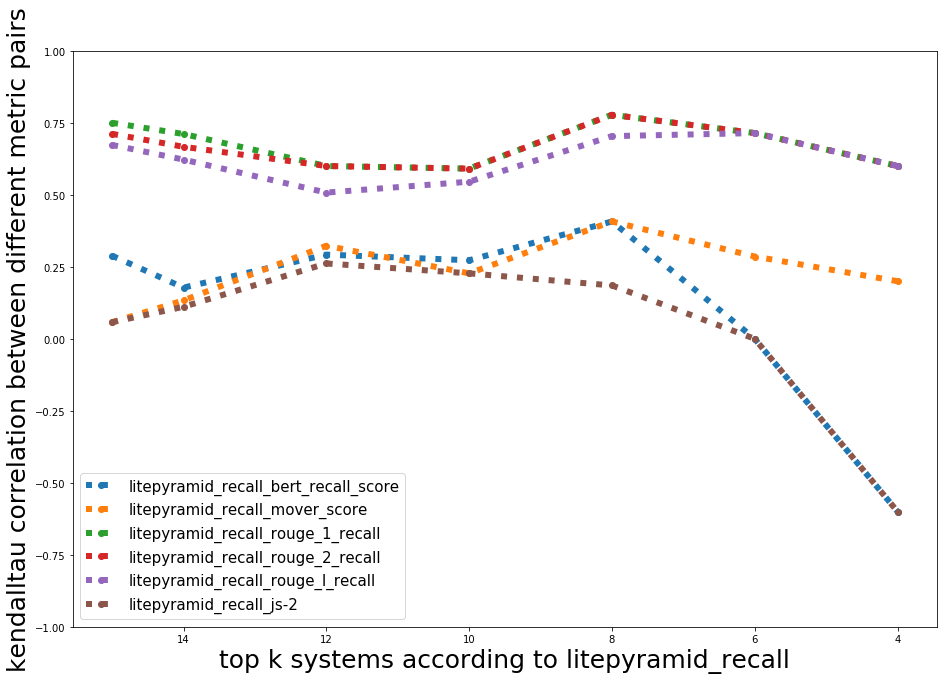

In [20]:
# plot k vs disagreements
kvalues = [15, 14, 12, 10, 8, 6, 4]
all_pairs = [('litepyramid_recall', m) for m in mlist if m != 'litepyramid_recall']
systems = utils.get_system_level_scores(sd, mlist, agg='mean')
sorting_metric = 'litepyramid_recall'
correlation_method = 'kendalltau'

y = ddict(list)
for k in kvalues:
    top_ksystems = utils.get_topk(systems, k, metric=sorting_metric)
    corr, pval = utils.get_correlation(top_ksystems, metric_pairs=all_pairs, method=correlation_method)
    for key in corr:
        y[key].append(corr[key])
        
data = {
    'x': kvalues,
    **y,
}
labels = list(y.keys())

ax = plt.axes([0, 0, 2, 2])
lines = []
for label in labels:
    lines.append(ax.plot('x', label, data=data, linewidth=6.0, marker='o',
                         linestyle=':' if 'pyramid' in label else None))
plt.gca().invert_xaxis()
ax.legend(prop={'size': 15})
ax.set_xlabel(f"top k systems according to {sorting_metric}", fontsize=25)
ax.set_ylabel(f"{correlation_method} correlation between different metric pairs", fontsize=25)
plt.ylim(-1, 1)

# Bootstrap Resampling - Exp III

In [21]:
systems = utils.get_system_level_scores(sd, mlist, agg='none')
sys_names = list(systems.keys())
all_system_pairs = list(itertools.combinations(sys_names, 2))

In [24]:
def get_predictions_br(system_pairs, systems, metric):
    preds = {}
    for pair in system_pairs:
        sys1 = systems[pair[0]][metric]
        sys2 = systems[pair[1]][metric]
        n = len(sys1)
        points = [i for i in range(0, n)]
        is_better = 0
        N = 1000
        for i in range(N):
            sample = choices(points, k=n)
            sys1_ = [sys1[p] for p in sample]
            sys2_ = [sys2[p] for p in sample]
            if np.mean(sys1_) > np.mean(sys2_):
                is_better += 1
                
        if is_better/N >= 0.95:
            preds[pair] = 0 # pair[0] is better
        elif is_better/N <= 0.05:
            preds[pair] = 1 # pair[1] is better
        else:
            preds[pair] = 2 # can't say
    return preds

In [23]:
human_judgements = get_predictions_br(all_system_pairs, systems, 'litepyramid_recall')

In [21]:
y_true = [human_judgements[pair] for pair in all_system_pairs]
metrics = mlist
for metric in metrics:
    metric_predictions = get_predictions_br(all_system_pairs, systems, metric)
    
    y_pred = [metric_predictions[pair] for pair in all_system_pairs]
#     print('confusion metrics ', metric)
    print(confusion_matrix(y_true, y_pred))
    print(metric, f1_score(y_true, y_pred, average='weighted'))

[[16  2  7]
 [ 1 39  3]
 [ 6 15 16]]
bert_recall_score 0.6603724318010031
[[18  2  5]
 [ 1 35  7]
 [10 10 17]]
mover_score 0.6587782587782587
[[21  0  4]
 [ 0 33 10]
 [10  8 19]]
rouge_1_recall 0.6916326530612246
[[21  0  4]
 [ 0 36  7]
 [ 4  4 29]]
rouge_2_recall 0.8206793779943522
[[21  1  3]
 [ 0 34  9]
 [ 9  9 19]]
rouge_l_recall 0.6988245245851735
[[20  0  5]
 [ 1 33  9]
 [ 8  6 23]]
js-2 0.7250311868198047
[[24  0  1]
 [ 0 41  2]
 [ 0  1 36]]
litepyramid_recall 0.9621407660808685


# Summary level analysis - Exp IV

In [25]:
np.set_printoptions(precision=4)

In [26]:
metrics = mlist
utils.print_ktau_matrix(metrics, percentile=[(0, 100)], sd=sd, cutoff_metric='litepyramid_recall', y_type='ktau')

['bert_recall_score', 'mover_score', 'rouge_1_recall', 'rouge_2_recall', 'rouge_l_recall', 'js-2', 'litepyramid_recall']
[[0.     0.5434 0.5811 0.5996 0.58   0.5129 0.4684]]

[[0.     0.     0.4774 0.5562 0.4774 0.5888 0.436 ]]

[[0.     0.     0.     0.682  0.8626 0.5067 0.4891]]

[[0.     0.     0.     0.     0.7006 0.7258 0.486 ]]

[[0.     0.     0.     0.     0.     0.5154 0.4871]]

[[0.     0.     0.     0.     0.     0.     0.4255]]

[[0. 0. 0. 0. 0. 0. 0.]]

total 476/2100.0 = 22.666666666666668% values ignored


[0.46838622087890563,
 0.43599197955352864,
 0.48913594431561247,
 0.4859542610414608,
 0.4870908341119741,
 0.4254850921291276]